In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
from torch.nn import functional as nnf
from tqdm import tqdm

In [2]:
data = pd.read_csv('toy_example.csv')
x = data['x'].to_numpy()
y = data['y'].to_numpy()

In [3]:
class ToyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes=[1, 64, 128, 256, 512, 256, 128, 64, 1]):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())
                modules.append(nn.Dropout(0.1))

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)

In [6]:
dataset = ToyDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# check if cuda is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"The model is running on {device}.")

model = MLP().to(device)

The model is running on cpu.


In [7]:
epochs = 200

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.5)

for epoch in tqdm(range(epochs)):
    for x, y in dataloader:
        x = x[:, None].float().to(device)
        y = y[:, None].float().to(device)
        pred = model(x)

        optimizer.zero_grad()
        loss = nnf.mse_loss(pred, y)
        loss.backward()
        optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


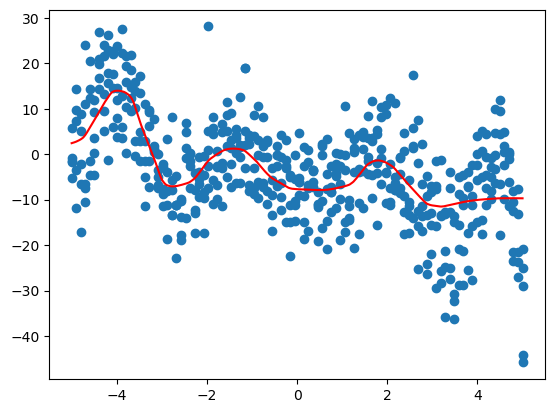

In [8]:
data = pd.read_csv('toy_example.csv')
x = data['x'].to_numpy()
y = data['y'].to_numpy()
plt.scatter(x, y)

x_seq = torch.linspace(-5, 5, 500)[:, None].to(device)
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')